# 程序运行说明
1. 请确保运行环境中包含cuda,若没有cuda,RNN运算将非常慢。
2. 当前版本CNN、RNN以及全连接参数均为最后测试的参数版本。如果需要测试其他参数的效果,麻烦手动修改以下参数。
3. CNN\RNN在运行前注意修改输入参数的格式。修改格式均包含在**模型训练**部分。

以上

张艺峰

## K折叠交叉验证数据集分割

In [155]:
import torch.nn as nn
import torch
import torch.utils.data as data
import pandas as pd


def get_k_fold(k, n, x_total, y_total):
    '''
        K-fold 分割函数, 用于进行交叉验证训练
        传入参数: 
            k: 总分割组数
            n: 本次所需的测试组组别
            x_total: 整体features,类型为dataframe,下同
            y_total: 整体labels
        
        传出参数：
            x_train, y_train: 对应训练集的输入输出
            x_valid, y_valid: 对应测试集的输入输出

        注意: 此函数仅适合处理y为一维的情况
    '''
    assert k > 1
    fold_size = y_total.shape[0] // k
    x_train, y_train = None, None
    for i in range(k):
        lo = slice(i * fold_size, (i + 1) * fold_size)
        x_temp, y_temp = x_total.iloc[lo, :], y_total.iloc[lo]
        if i == n:
            x_valid = x_temp
            y_valid = y_temp
        elif x_train is None:
            x_train, y_train = x_temp, y_temp
        else:
            x_train = pd.concat([x_train, x_temp], axis=0)
            y_train = pd.concat([y_train, y_temp], axis=0)

    return torch.tensor(x_train.values), torch.tensor(y_train.values), torch.tensor(x_valid.values), torch.tensor(y_valid.values)

## 全连接函数模型

In [156]:
'''
    全连接模型
'''

class fcModel(nn.Module):
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim, act_fun):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, h1_dim), act_fun)
        self.layer2 = nn.Sequential(nn.Linear(h1_dim, h2_dim), act_fun)
        self.layer3 = nn.Linear(h2_dim, out_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

## CNN神经网络模型

In [157]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, padding=1), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3, padding=1), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.linear = nn.Linear(64*47, 4)

    def forward(self, x):
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = x.view(-1, 64*47)
        x = self.linear(x)

        return x

## RNN神经网络LSTM

In [158]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, 4)
        self.hidden_size = hidden_size

    def forward(self, x):
        hidden = (torch.zeros(self.num_layers * 2, x.shape[0], self.hidden_size).cuda(),
                  torch.zeros(self.num_layers * 2, x.shape[0], self.hidden_size).cuda())
        out,_= self.lstm(x, hidden)
        # print(out.shape)
        out = self.linear(out[:, -1, :])
        return out

## 注意力RNN神经网络

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 4)
    
    def forward(self, x):
        hidden = (torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda(),
                  torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda())

        out, _ = self.lstm(x, hidden)
        out = self.linear(out[:, -1, :])
        return out

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(self.hidden_size, 1)
    
    def forward(self, hidden_states):
        # hidden_states: tensor of shape (batch_size, seq_length, hidden_size)
        aw = F.softmax(self.attention(hidden_states), dim=1)
        cv = aw * hidden_states
        # cv = cv.sum(dim=1)
        
        return cv, aw

class RNNWithAttention(nn.Module):
    def __init__(self, i_size=1, h_size=5):
        super(RNNWithAttention, self).__init__()
        self.rnn1 = RNN(input_size=i_size, hidden_size=h_size)
        self.batchnorm = nn.BatchNorm1d(h_size - 1)
        self.linear = nn.Linear(h_size - 1, h_size)
        self.rnn2 = RNN(input_size=h_size, hidden_size=h_size)
        self.attention = Attention(h_size)
        self.linear2 = nn.Linear(h_size, 4)
    
    def forward(self, x):
        x = self.rnn1(x)
        x = self.batchnorm(x)
        x = F.relu(self.linear(x))
        x, _ = self.attention(x)
        x = x.unsqueeze(1)
        x = self.rnn2(x)
        return x

## 数据读取

In [160]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
datas = pd.read_csv("./ecg_data.csv", header=None)
# datas = shuffle(origin_data)
ydatas = datas.iloc[:,188]
xdatas = datas.drop(datas.columns[188], axis=1)
ydatas = ydatas.to_frame()
k = 5

## 模型训练与结果预测

f1score for normal is:  0.882
f1score for AF is:  0.6887
f1score for 3 is:  0.6884
average f1score is:  0.753


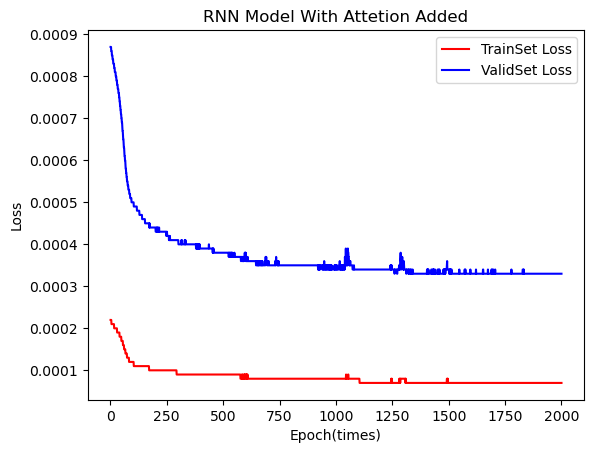

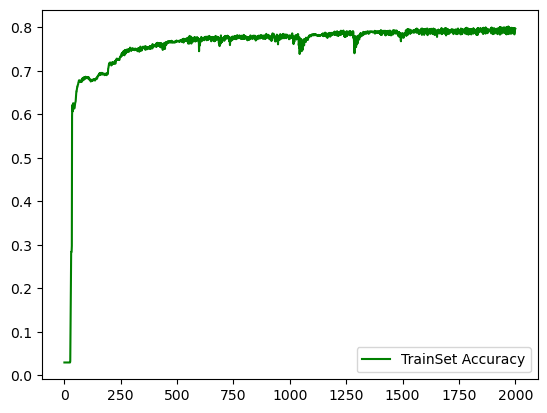

f1score for normal is:  0.8772
f1score for AF is:  0.731
f1score for 3 is:  0.6247
average f1score is:  0.7443


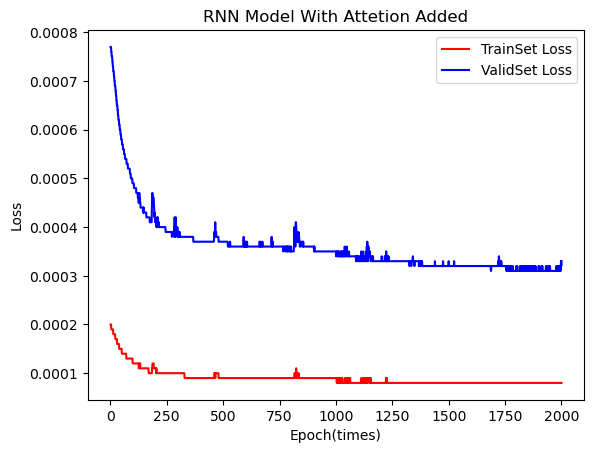

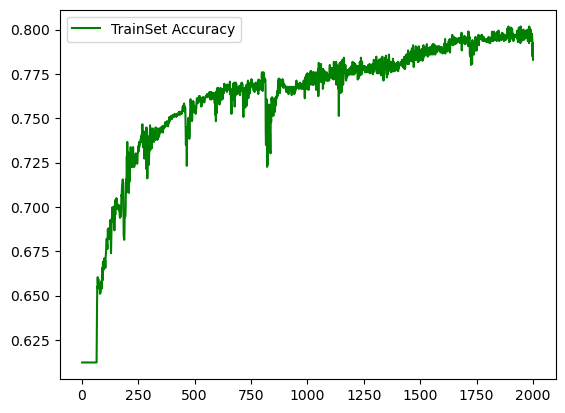

f1score for normal is:  0.8748
f1score for AF is:  0.6264
f1score for 3 is:  0.5993
average f1score is:  0.7002


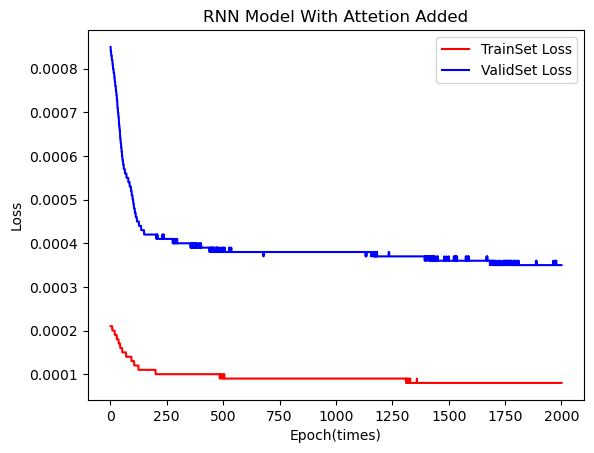

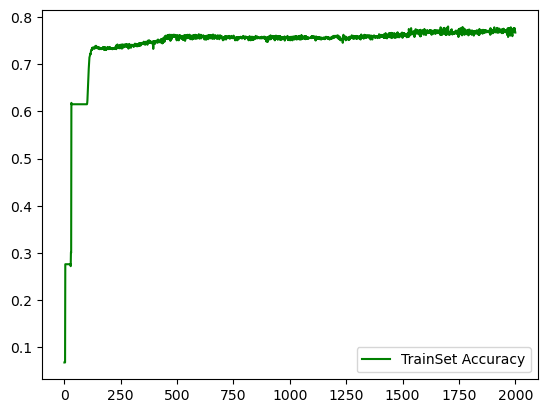

f1score for normal is:  0.8539
f1score for AF is:  0.4609
f1score for 3 is:  0.5943
average f1score is:  0.6364


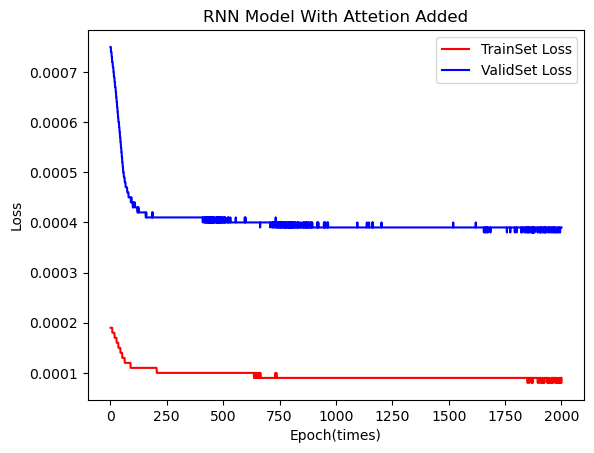

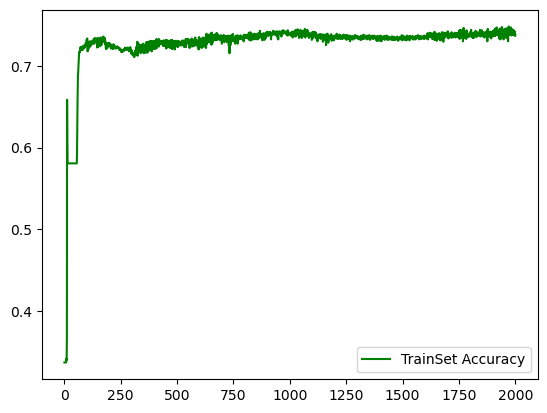

f1score for normal is:  0.8745
f1score for AF is:  0.4845
f1score for 3 is:  0.6364
average f1score is:  0.6651


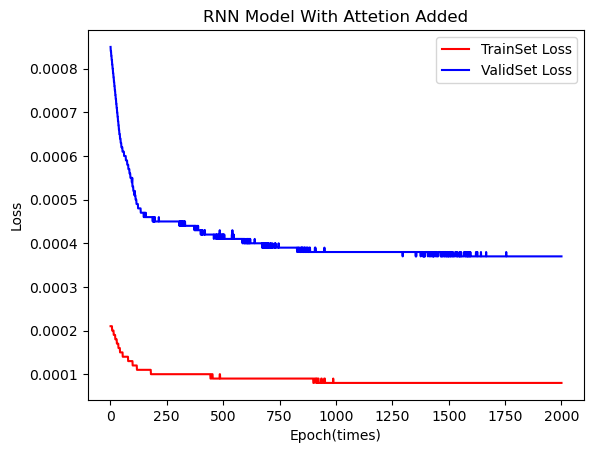

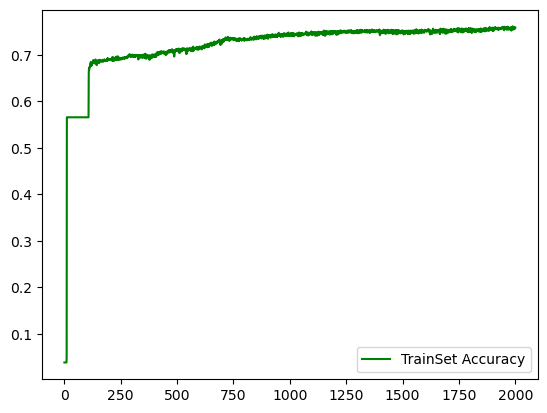

In [161]:
import numpy as np
from sklearn.metrics import f1_score

train_num = 2000
axis = [i + 1 for i in range(train_num)]
trainLoss = [0 for i in range(train_num)]
trainAccuracy = [0 for i in range(train_num)]
validLoss = [0 for i in range(train_num)]


for i in range(k):

    # 数据加载
    train_x, train_y, valid_x, valid_y = get_k_fold(k, i, xdatas, ydatas)
    length = len(train_y)

    activate = nn.ReLU()
    # model = fcModel(188, 128, 64, 4, act_fun=activate)
    # model = CNN()
    # model = LSTM()
    model = RNNWithAttention()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 全连接0.00005, CNN0.0001, RNN 0.005

    train_y = train_y - torch.ones(train_y.size())
    train_y = train_y.to(torch.long)
    train_y = train_y.squeeze()
    valid_y = valid_y - torch.ones(valid_y.size())
    valid_y = valid_y.to(torch.long)
    valid_y = valid_y.squeeze()

    # # 为CNN调整输入格式
    # train_x = train_x.reshape(-1, 1, 188)
    # valid_x = valid_x.reshape(-1, 1, 188)

    # 为RNN修改输入形式
    train_x = train_x.unsqueeze(2)
    #train_x = train_x.permute(1,0,2)
    valid_x = valid_x.unsqueeze(2)
    #valid_x = valid_x.permute(1,0,2)

    train_x = train_x.cuda()
    train_y = train_y.cuda()
    valid_x = valid_x.cuda()
    valid_y = valid_y.cuda()
    model = model.cuda()
    
    # 模型训练
    for epoch in range(train_num):
        optimizer.zero_grad()

        y_pred = model(train_x.to(torch.float32))
        y_pred = y_pred.to(torch.float32)
        loss = loss_fn(y_pred, train_y.to(torch.long)).sum() / len(train_y)
        loss.backward()
        optimizer.step()
        # break

        y_val = model(valid_x.to(torch.float32))
        loss_val = loss_fn(y_val, valid_y.to(torch.long)).sum() / len(valid_y)

        trainLoss[epoch] = round(loss.item(),5)
        validLoss[epoch] = round(loss_val.item(),5)
        y_acc = torch.argmax(y_val, dim=1)
        y_acc = y_acc.cpu()
        y_acc = y_acc.numpy()
        y_temp = valid_y.cpu()
        y_temp = y_temp.numpy()
        trainAccuracy[epoch] = round(np.sum(y_temp == y_acc) * 1.0 / len(y_temp), 5)
        # if (epoch+1) % 50 == 0:
        #     print("Epoch: ", epoch+1, " loss: ", round(loss.item(), 5))
        #     trainLoss[epoch//25] = round(loss.item(),2)
        #     validLoss[epoch//25] = round(loss_val.item(),2)

    y_val = model(valid_x.to(torch.float32))
    acc_y = torch.argmax(y_val, dim=1)
    acc_y = acc_y.cpu()
    acc_y = acc_y.numpy()
    temp_y = valid_y.cpu()
    temp_y = temp_y.numpy()

    score = np.array([f1_score(acc_y, temp_y, labels=[0], average='micro'),
                      f1_score(acc_y, temp_y, labels=[1], average='micro'),
                      f1_score(acc_y, temp_y, labels=[2], average='micro'),])

    print("f1score for normal is: ",round(score[0],4))
    print("f1score for AF is: ",round(score[1],4))
    print("f1score for 3 is: ",round(score[2],4))
    print("average f1score is: ",round(score.sum()*1.0 / len(score),4))

    plt.figure(k)
    plt.plot(axis, trainLoss, color="r", label="TrainSet Loss")
    plt.plot(axis, validLoss, color="b", label="ValidSet Loss")
    plt.xlabel("Epoch(times)")
    plt.ylabel("Loss")
    plt.title("RNN Model With Attetion Added")
    plt.legend()
    plt.show()
    plt.figure(k+5)
    plt.plot(axis, trainAccuracy, color="g", label="TrainSet Accuracy")
    plt.legend()
    plt.show()